# Exercise 3-2

In [1]:
import pysindy as ps
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "font.size": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

### Numerical Simulation

In [3]:
def lorenz_dynamics(
    t: float,
    x: ArrayLike,
    sigma: float=10,
    rho: float=28,
    beta: float=8/3,
) -> NDArray:
    """Dynamics of the Lorenz system

    Args:
        x (ArrayLike): N x 3 array of [x, y, z]
        sigma (float, optional): Model parameter. Defaults to 10.
        rho (float, optional): Model parameter. Defaults to 28.
        beta (float, optional): Model parameter. Defaults to 8/3.

    Returns:
        NDArray: Nx3 array of time derivatives of x1 and x2
    """
    xdot = np.empty_like(x)
    xdot[0] = sigma * (x[1] - x[0])
    xdot[1] = x[0] * (rho - x[2]) - x[1]
    xdot[2] = x[0] * x[1] - beta * x[2]
    return xdot

In [4]:
# Compute trajectory
x0 = np.array([0, 1, 20])
dt = 0.0001
t = np.arange(0, 10+dt, dt)
solution = solve_ivp(lorenz_dynamics, (t[0], t[-1]), x0, t_eval=t)
x = solution.y.T[int(1/dt):]  # truncate first t=1 of data
t = t[int(1/dt):]

### 3.2.1 SINDy Data Length Study

In [5]:
t_ends = [0.5, 1, 1.5, 2]
feature_library = ps.feature_library.PolynomialLibrary(degree=2)
for t_end in t_ends:
    idx_end = int(t_end / dt)
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.2), feature_names=["x", "y", "z"])
    model.fit(x[:idx_end], t=t[:idx_end])
    print(f"simulation time: {t_end}")
    model.print()
    print("")

simulation time: 0.5
(x)' = -10.003 x + 10.003 y
(y)' = 0.247 1 + 28.081 x + -1.021 y + -1.000 x z
(z)' = -55.597 1 + 36.681 x + -20.192 y + 0.462 z + -1.891 x^2 + 1.803 x y + -1.312 x z + 0.498 y z

simulation time: 1
(x)' = -9.992 x + 9.998 y
(y)' = 0.252 1 + 28.289 x + -1.095 y + -1.005 x z
(z)' = -2.662 z + 0.999 x y

simulation time: 1.5
(x)' = -10.006 x + 10.007 y
(y)' = 9.241 1 + 3.013 x + 11.052 y + -0.732 z + 1.443 x^2 + -0.684 x y + -0.346 y z
(z)' = -2.665 z + 1.000 x y

simulation time: 2
(x)' = -10.005 x + 10.005 y
(y)' = 27.782 x + -0.960 y + -0.992 x z
(z)' = -2.665 z + 0.999 x y



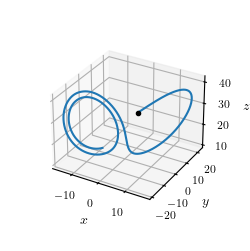

In [6]:
# Plot phase portrait up to t=2
t_end = 2
idx_end = int(2 / dt)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection="3d")
ax.plot(x[:idx_end, 0], x[:idx_end, 1], x[:idx_end, 2])
ax.plot(x[idx_end, 0], x[idx_end, 1], x[idx_end, 2], ".k")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
# ax.set_title("Lorenz System Phase Portrait")
ax.grid(True)
ax.set_box_aspect(None, zoom=0.75)  # fix z-axis label off canvas
fig.savefig("p2fig1.pdf", bbox_inches="tight")
plt.show()

In [7]:
# Store the coefficient matrix from the last model
Phi_mask = model.coefficients().astype(bool)

### 3.2.2 SINDy Sampling Rate Study

In [8]:
dt_base = 0.0001
dts = [0.0001, 0.001, 0.01, 0.1]
t_ends = [0.5, 1, 2, 4, 9]
feature_library = ps.feature_library.PolynomialLibrary(degree=2)
for dt in dts:
    skip = int(dt / dt_base)
    for t_end in t_ends:
        idx_end = int(t_end / dt_base)
        model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.2), feature_names=["x", "y", "z"])
        model.fit(x[:idx_end:skip], t[:idx_end:skip])
        print(f"time step: {dt}")
        print(f"simulation time: {t_end}")
        if np.all(model.coefficients().astype(bool)== Phi_mask):
            print("🟩 SPARSITY PASS\n")
        else:
            print("🟥 SPARSITY FAIL\n")

time step: 0.0001
simulation time: 0.5
🟥 SPARSITY FAIL

time step: 0.0001
simulation time: 1
🟥 SPARSITY FAIL

time step: 0.0001
simulation time: 2
🟩 SPARSITY PASS

time step: 0.0001
simulation time: 4
🟩 SPARSITY PASS

time step: 0.0001
simulation time: 9
🟩 SPARSITY PASS

time step: 0.001
simulation time: 0.5
🟥 SPARSITY FAIL

time step: 0.001
simulation time: 1
🟥 SPARSITY FAIL

time step: 0.001
simulation time: 2
🟩 SPARSITY PASS

time step: 0.001
simulation time: 4
🟩 SPARSITY PASS

time step: 0.001
simulation time: 9
🟩 SPARSITY PASS

time step: 0.01
simulation time: 0.5
🟥 SPARSITY FAIL

time step: 0.01
simulation time: 1
🟥 SPARSITY FAIL

time step: 0.01
simulation time: 2
🟥 SPARSITY FAIL

time step: 0.01
simulation time: 4
🟩 SPARSITY PASS

time step: 0.01
simulation time: 9
🟩 SPARSITY PASS

time step: 0.1
simulation time: 0.5
🟥 SPARSITY FAIL

time step: 0.1
simulation time: 1
🟥 SPARSITY FAIL

time step: 0.1
simulation time: 2
🟥 SPARSITY FAIL

time step: 0.1
simulation time: 4
🟥 SPARSITY

### 3.1.3 SINDy Noise Study

In [9]:
dt = dt_base
noise_seeds = list(range(50))
noise_stds = np.logspace(-2, 0, 65)
t_ends = [0.5, 1, 2, 4, 9]
probability_matrix = np.empty((len(noise_stds), len(t_ends)))
feature_library = ps.feature_library.PolynomialLibrary(degree=2)
for i, noise_std in enumerate(noise_stds):
    for j, t_end in enumerate(t_ends):
        success_mask = []
        for noise_seed in noise_seeds:
            np.random.seed(noise_seed)
            idx_end = int(t_end / dt_base)
            noise = noise_std * np.random.randn(*x[:idx_end].shape)
            model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.2), feature_names=["x", "y", "z"])
            model.fit(x[:idx_end] + noise, t[:idx_end])
            if np.all(model.coefficients().astype(bool)== Phi_mask):
                success_mask.append(True)
            else:
                success_mask.append(False)
        probability_matrix[i, j] = sum(success_mask) / len(success_mask)

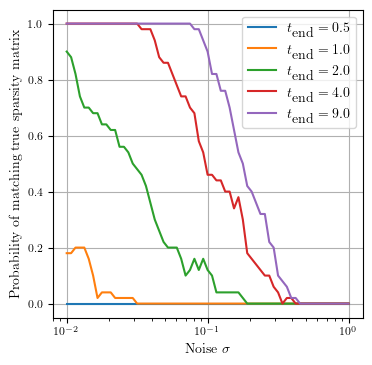

In [10]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_xscale("log")
for t_end, t_end_probabilities in zip(t_ends, probability_matrix.T):
    label = r"$t_{\textrm{end}}=" + f"{t_end:2.1f}$"
    ax.plot(noise_stds, t_end_probabilities, label=label)
ax.set_xlabel("Noise $\sigma$")
ax.set_ylabel("Probability of matching true sparsity matrix")
ax.legend()
ax.grid(True)
fig.savefig("p2fig2.pdf", bbox_inches="tight")
plt.show()